In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 

%reload_ext autoreload
%aimport Funcs
%aimport fluid_flow
%aimport parameters
from Funcs import advance_adv_diff_RK3
from fluid_flow import advance_fluid_flow, set_boundary, dt_fluid_flow

from parameters import * # <-- dangerous; make sure to put only global constants in that file

In [2]:
N, M = 50,50
dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,M)
dt = dt_fluid_flow(dx, Fo=0.3)

## stationnarity
We define some metrics which compare two arrays $a$ and $b$. In our case this will be $u$ or $v$ at different times $T_n$ of the simulation.

In [19]:
def metric_L0(a, b):
    norm = np.abs(a).max()
    return np.abs(a-b).max() / norm

def metric_RMS(a, b):
    norm = np.abs(a).max()
    return np.sqrt(np.mean((a-b)**2)) / norm

Next, we define $t_n = n \cdot Nt \,  \Delta t + t_0$ of the simulation, where $n = 1,.., N_{loop}$, $t_0 = N_{t_0} \Delta t$ is the initial time given to the simulation before starting with the actual analysis (we are not interested in the strong fluctuations at the very beginning). Furthermore, one can chose $N_t \gg 1$ since we don't need to compare the results after every single time step.

In [20]:
from math import sin, pi

# initial setup of velocity field
u0 = np.zeros((N,M))
v0 = np.copy(u0)
u0,v0 = set_boundary(u0,v0,Ns_c, Nc_lw)
u, v = np.copy(u0), np.copy(v0)

# initial convergence paramater for the Poisson solver:
atol0 = 1e-4

# initial w parameter for the Poisson solver:
w0 = 2 / (1 + sin(pi/N))

# initial iterations before staerting the analysis
Nt0 = 500

# number of iterations between 2 convergence measurements
Nt = 50

# number of convergence measurements
N_loop = 300

# placeholders for the respective metrics
L0 = np.zeros((2,N_loop))
L2 = np.zeros_like(L0)

# initial warm-up:
u, v, P = advance_fluid_flow(Nt0, u, v, advance_adv_diff_RK3, dt)

# convergence analysis:
for i in range(N_loop):
    
    w = w0 # modifying this param. doesn't yield satisfactory results
    atol = atol0*1./(20*i + 1.) # here, we gradually reduce the convergence threshold
    
    u_old, v_old = np.copy(u), np.copy(v)
    u, v, P = advance_fluid_flow(Nt, u, v, advance_adv_diff_RK3, dt, w=w, atol=atol, P=P)
    
    # measurements:
    L0[0,i] = metric_L0(u_old, u)
    L0[1,i] = metric_L0(v_old, v)
    
    L2[0,i] = metric_RMS(u_old, u)
    L2[1,i] = metric_RMS(v_old, v)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
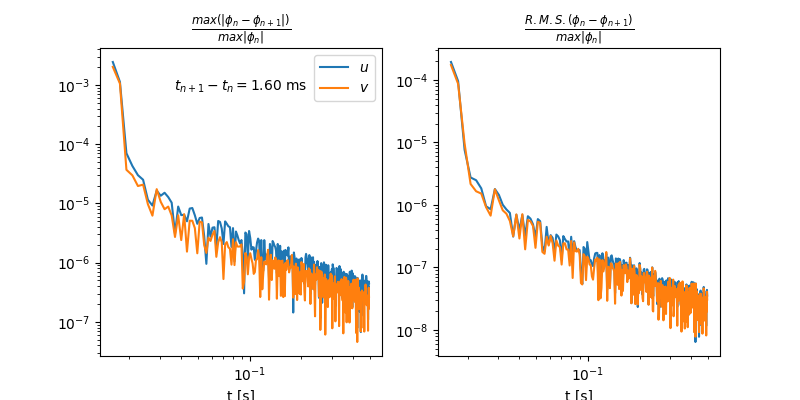

In [17]:
T = np.arange(N_loop) * dt * Nt + dt * Nt_init

fig, [ax, ax2] = plt.subplots(1,2, figsize=(8,4), sharex=True)
ax.plot(T, L0[0], label='$u$')
ax.plot(T, L0[1], label='$v$')

ax2.plot(T, L2[0], label='$u$')
ax2.plot(T, L2[1], label='$v$')

ax.set_xlabel('t [s]')
ax2.set_xlabel('t [s]')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_xscale('log')
ax2.set_xscale('log')

ax.set_title(r'$\frac{ max ( |\phi_n - \phi_{n+1}| ) } { max |\phi_n| }$')
ax2.set_title(r'$\frac{ R.M.S.( \phi_n - \phi_{n+1} ) }{ max |\phi_n| }$')

s = r'$t_{n+1} - t_n = $' +'${:.2f}$ ms'.format(Nt * dt * 1e3)
ax.text(0.5, 0.9, s, verticalalignment='top', horizontalalignment='center', transform=ax.transAxes)
ax.legend()

**Maximum strain rate**

what is max($|\frac{\partial v}{\partial y}|$) ?


In [6]:
from Funcs import df1_2
a = np.abs(df1_2(v, dy, axis=1))
print(np.max(a[0,:]))

1480.1496387171076


In [7]:
np.max(np.abs(u)),np.max(np.abs(v)) 

(1.1309909108702783, 1.0)

We can save the velocity field for later use:

In [8]:
from pathlib import Path
datap = Path('data/vel_field') / 'N{}M{}.npy'.format(N,M)
np.save(datap, np.array([u,v]))

## Visualization

In [9]:

from visualization import plot_velocity_image, plot_velocity_vector_field

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
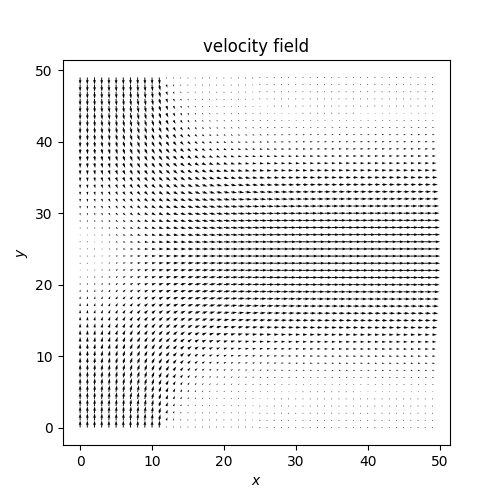

In [10]:
plot_velocity_vector_field(u,v)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
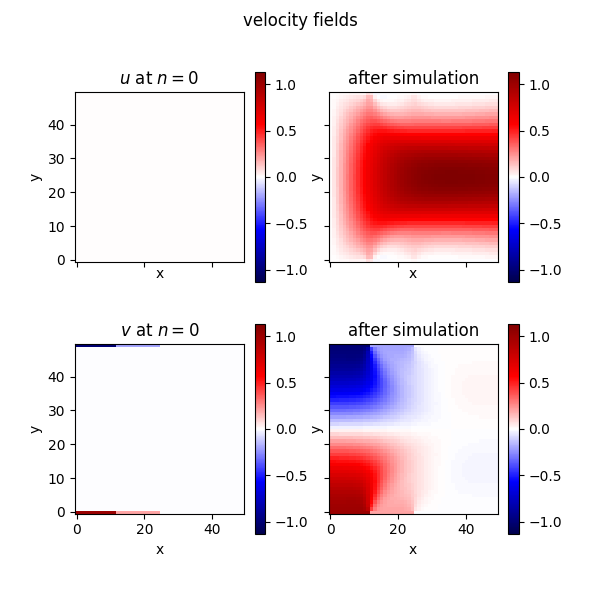

In [11]:
from visualization import plot_velocity_image
plot_velocity_image(u,v,u0,v0)